<a href="https://colab.research.google.com/github/tomasz-soltysiak/Fraud_transaction/blob/oversampling/Fraud_dedection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score,roc_curve,confusion_matrix,roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from keras.layers import Dense
from keras.layers import Dropout
from xgboost import XGBClassifier
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense
from keras.layers import Dropout
! pip install joblib
from joblib import dump, load
from mlxtend.classifier import EnsembleVoteClassifier

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


After adding libraries, I upload data.

In [0]:
df=pd.read_csv('/content/drive/My Drive/Data Science/ML fraud detection/data.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,127614.0,2.004188,-0.287498,-1.984934,0.342239,0.413188,-0.815346,0.445456,-0.299258,0.562445,0.109932,-1.381862,-0.428037,-1.230877,0.629739,-0.242149,-0.388169,-0.137390,-0.552790,0.315548,-0.152272,-0.038661,-0.127194,0.036464,0.504076,0.176423,0.541252,-0.121212,-0.064948,64.99,0
1,139389.0,2.346905,-1.264915,-1.034900,-1.568721,-1.122435,-0.790624,-1.011732,-0.268243,-1.229191,1.576645,-1.286030,-0.816409,0.603102,-0.437890,-0.164642,-0.582255,0.427399,-0.134499,-0.049048,-0.460329,-0.196288,0.015015,0.197023,-0.432445,-0.119139,-0.131627,0.015176,-0.058104,1.00,0
2,68482.0,-3.089671,2.464689,0.042745,1.670674,-2.129076,0.600262,-1.627286,2.452801,0.319063,-0.526330,-1.681347,1.951140,1.001432,0.346440,-1.625289,-1.128464,1.888585,-1.045530,1.149073,-0.060298,-0.223384,-0.441265,0.250283,0.091483,-0.038373,-0.410096,0.088944,0.026973,30.70,0
3,123677.0,1.792358,-0.384458,-2.170063,0.096243,0.291162,-1.510182,0.921037,-0.525263,-0.088484,0.119203,1.171025,1.013250,-0.123025,1.041171,-0.323426,-0.460035,-0.465857,-0.061338,0.309959,0.072457,0.297749,0.633531,-0.176001,0.146116,0.342753,0.198887,-0.117734,-0.061706,154.09,0
4,121222.0,2.188008,-0.400212,-1.627908,-0.225692,-0.133549,-1.273351,0.226144,-0.553975,-0.908684,0.877520,-0.845913,0.763512,1.478457,0.027869,-0.734253,-2.244708,0.184697,0.251184,-0.646467,-0.558023,-0.338599,-0.220436,0.112804,0.049313,0.157236,0.606729,-0.063450,-0.071105,10.00,0


In [0]:
df=df.dropna(axis=0)
df.isnull().sum(axis=0)

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Legend does not support 'F' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Legend does not support 'a' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Legend does not sup

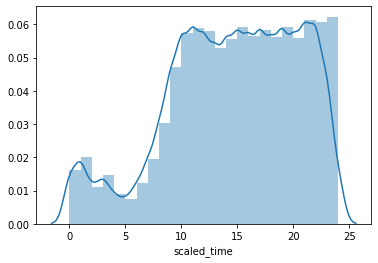

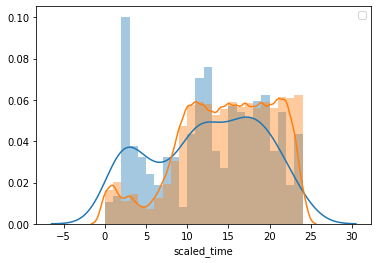

In [0]:
np.floor((172792/3600)%24)
np.floor((89000/3600)%24)
df['scaled_time']=round((df['Time']/3600)%24)


In [0]:
Rob_scaler=RobustScaler()

df['scaled_Amount']=Rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,scaled_time,scaled_Amount
0,127614.0,2.004188,-0.287498,-1.984934,0.342239,0.413188,-0.815346,0.445456,-0.299258,0.562445,0.109932,-1.381862,-0.428037,-1.230877,0.629739,-0.242149,-0.388169,-0.137390,-0.552790,0.315548,-0.152272,-0.038661,-0.127194,0.036464,0.504076,0.176423,0.541252,-0.121212,-0.064948,64.99,0,11.0,0.601848
1,139389.0,2.346905,-1.264915,-1.034900,-1.568721,-1.122435,-0.790624,-1.011732,-0.268243,-1.229191,1.576645,-1.286030,-0.816409,0.603102,-0.437890,-0.164642,-0.582255,0.427399,-0.134499,-0.049048,-0.460329,-0.196288,0.015015,0.197023,-0.432445,-0.119139,-0.131627,0.015176,-0.058104,1.00,0,15.0,-0.293994
2,68482.0,-3.089671,2.464689,0.042745,1.670674,-2.129076,0.600262,-1.627286,2.452801,0.319063,-0.526330,-1.681347,1.951140,1.001432,0.346440,-1.625289,-1.128464,1.888585,-1.045530,1.149073,-0.060298,-0.223384,-0.441265,0.250283,0.091483,-0.038373,-0.410096,0.088944,0.026973,30.70,0,19.0,0.121798
3,123677.0,1.792358,-0.384458,-2.170063,0.096243,0.291162,-1.510182,0.921037,-0.525263,-0.088484,0.119203,1.171025,1.013250,-0.123025,1.041171,-0.323426,-0.460035,-0.465857,-0.061338,0.309959,0.072457,0.297749,0.633531,-0.176001,0.146116,0.342753,0.198887,-0.117734,-0.061706,154.09,0,10.0,1.849223
4,121222.0,2.188008,-0.400212,-1.627908,-0.225692,-0.133549,-1.273351,0.226144,-0.553975,-0.908684,0.877520,-0.845913,0.763512,1.478457,0.027869,-0.734253,-2.244708,0.184697,0.251184,-0.646467,-0.558023,-0.338599,-0.220436,0.112804,0.049313,0.157236,0.606729,-0.063450,-0.071105,10.00,0,10.0,-0.167997


In [0]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
df_X = df.iloc[:, 0:32]
X_resampled, y_resampled = ros.fit_resample(df_X, df['Class'])


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [0]:
X_resampled_cols = list(df.columns.values)
X_resampled_cols.remove('Class')
df_ovsmpl = pd.DataFrame(X_resampled, columns=X_resampled_cols)
df_ovsmpl['Class']=pd.DataFrame(y_resampled)

In [0]:
df_ovsmpl=df_ovsmpl.drop(['Time','Amount'],axis=1)
df_ovsmpl.head()

X=df_ovsmpl.drop(columns=['Class'],axis=1)
y=df_ovsmpl['Class']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=42)

KeyError: ignored

In [0]:
def Log_reg(X,y):
  X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=42)
  log_reg=LogisticRegression()
  penalty=['l1','l2']
  C=np.logspace(0,4,20)
  hyperpara=dict(penalty=penalty,C=C)
  gridsearch=RandomizedSearchCV(log_reg,hyperpara)

  return gridsearch.fit(X_train,y_train)

def Rand_forest(X,y):
  X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=42)


  X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=42)
  RF=RandomForestClassifier(n_estimators=150)
  

  n_estimators=np.arange(1,20,1)
  criterion=['gini','entropy']
  
  hyperpara=dict(n_estimators=n_estimators,criterion=criterion)
  gridsearch=RandomizedSearchCV(RF,hyperpara)

  return gridsearch.fit(X_train,y_train)

def KNeig(X,y):
  X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=42)
  Kneig=KNeighborsClassifier(n_neighbors=5)
  n_neighbors=np.arange(1,10,1)
  weights=['uniform','distance']
  #algorithm=['auto', 'ball_tree', 'kd_tree', 'brute']
  hyperpara=dict(n_neighbors=n_neighbors)
  gridsearch=RandomizedSearchCV(Kneig,hyperpara)

  return gridsearch.fit(X_train,y_train)  
  
def XGBoost_(X,y):
  
  
  X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=42)
  xgb=XGBClassifier()
  n_estimators=np.arange(1,20,1)
  silent=[True,False]
  #max_depth=np.arange(1,20,1)  
  hyperpara=dict(n_estimators=n_estimators,silent=silent)
  gridsearch=RandomizedSearchCV(xgb,hyperpara)
  return gridsearch.fit(X_train,y_train) 
def SVC_(X,y):
  
  Sscaler=StandardScaler()
  X=Sscaler.fit_transform(X)
  X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=42)
  svc=SVC(kernel='rbf',random_state=0,gamma=1,C=1)
  C=np.arange(1,5,1)
  kernel=['linear', 'poly']
  hyperpara=dict(C=C,kernel=kernel)
  return RandomizedSearchCV(svc,hyperpara).fit(X_train,y_train)

In [0]:

import os.path
joblib.dump(Log_reg(X,y),'osmpl_Log_Reg.pkl')
joblib.dump(Rand_forest(X,y),'osmpl_Rand_forest.pkl')
joblib.dump(KNeig(X,y),'osmpl_KNeig.pkl')
joblib.dump(XGBoost_(X,y),'osmpl_XGBoost_.pkl')
joblib.dump(SVC_(X,y),'osmpl_SVC_.pkl')

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Defau

KeyboardInterrupt: ignored

In [0]:
from sklearn.externals import joblib
joblib.dump(XGBoost_(X,y),'osmpl_XGBoost_.pkl')


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


['osmpl_XGBoost_.pkl']

In [0]:
joblib.dump(KNeig(X,y),'osmpl_KNeig.pkl')
#joblib.dump(SVC_(X,y),'osmpl_SVC_.pkl')

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [0]:
def performance_of_models(x, y, list_of_models):
    results = [model_summary(model, x, y) for model in list_of_models]
    results = pd.DataFrame(results)
    return results

def model_summary(model, x, y):
  
  y_pred=model.predict(x)

  cnf_matrix = confusion_matrix(y_test, y_pred)
  precision=precision_score(y_test,y_pred)
  accuracy=accuracy_score(y_test,y_pred)
  recall=recall_score(y_test,y_pred)
  f1=f1_score(y_test,y_pred)
  auc=roc_auc_score(y_test, y_pred)
  fpr, tpr, trashhold = roc_curve(y_test,  y_pred)

  result = {'model': str(model),
            'confusion matrix': cnf_matrix,
            'precision': precision,
            'accuracy': accuracy,
            'recall': recall,
            'f1 score': f1,
            'auc': auc,
            'fpr': fpr,
            'tpr': tpr,
            'trashhold': trashhold,
              }

  return result

In [0]:
osmpl_LR = load('/content/osmpl_Log_Reg.pkl')
osmpl_RF = load('/content/osmpl_Rand_forest.pkl')
osmpl_XGB = load('/content/osmpl_XGBoost_.pkl')
osmpl_SVC = load('/content/osmpl_SVC_.pkl')

def eclf(X_train, y_train, list_of_modelspkl, list_of_weights):
  clfs = EnsembleVoteClassifier(clfs=list_of_modelspkl, voting='hard', refit=False, weights=list_of_weights)
  return clfs.fit(X_train, y_train)

list_of_modelspkl = [osmpl_LR, osmpl_RF, osmpl_XGB]
list_of_weights = [1, 1, 2]

d = eclf(X,y, list_of_modelspkl, list_of_weights)

dump(eclf, 'osmpl_eclf.pkl')

d

EnsembleVoteClassifier(clfs=[GridSearchCV(cv='warn',
                                          error_score='raise-deprecating',
                                          estimator=LogisticRegression(C=1.0,
                                                                       class_weight=None,
                                                                       dual=False,
                                                                       fit_intercept=True,
                                                                       intercept_scaling=1,
                                                                       l1_ratio=None,
                                                                       max_iter=100,
                                                                       multi_class='warn',
                                                                       n_jobs=None,
                                                                       penalty='l2',
       